# Agenda

---

<big>

1. The History of Spark - why does Spark exist?
    1.1 Spark vs. MapReduce


2. Spark's APIs - RDD, SQL (Spark_SQL, Spark_DataFrames), ML

---

In [ ]:
# Context variables are automatically created when spark starts.
sc.

In [ ]:
spark.

In [ ]:
# All Python libraries are available
import numpy as np
import pandas as pd

In [ ]:
from IPython.display import Image

im_0 = "http://snowplowanalytics.com/assets/img/blog/2015/05/spark_logo.png"
im_1 = "http://multithreaded.stitchfix.com/assets/images/blog/spark-post-images/fig1.png"
im_2 = "http://multithreaded.stitchfix.com/assets/images/blog/spark-post-images/fig2.png"

In [ ]:
Image(im_0)

---
> ## Spark is a cluster computing framework that can significantly increase the efficiency and capabilities of a data scientist’s workflow when dealing with distributed data. 

---
The Data Scientist must decide which of its many modules, features and options are appropriate for a given problem.

This course serves as an introduction and deep-dive to some of Spark's many rich features.

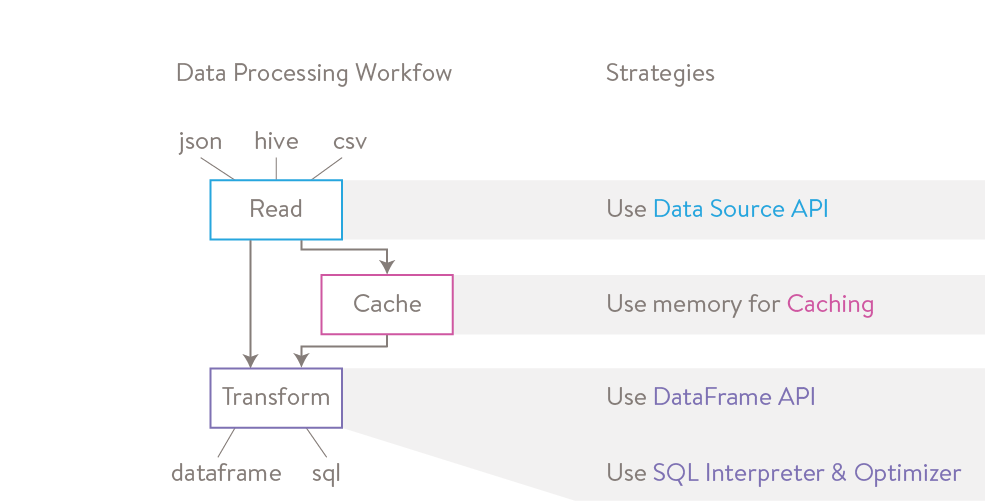

In [8]:
Image(im_1)

## Why Spark?

A Data Scientist's day-to-day work broadly includes the following:

- *Working with raw data to make it ML-ready*
    - import and export
    - manipulate
        - cleaning
        - transformations     
        - aggregations
        - random sampling


- *Exploratory Analysis of Data*
    - Applying statistical methods
    - Data Visualization
    - Feature Engineering


- *Building ML Models*
    - Fitting models to data
    - Variable Selection
    - Model Selection 
    - Parameter Tuning
    - Ensembling
    - Deployment
    
Most of these tasks can be performed on small/medium (a few millions of rows) sized data on a single machine. But as data outgrows a single machine/database, it becomes necessary to move to distributed platforms such as Hadoop and leverage a parallel computing paradigm such as MapReduce. 

---
### Limitations of `Hadoop` and `MapReduce`

Hadoop consists of a distributed filesystem (HDFS) and a parallel computation paradigm (MapReduce.) Map-Reduce involves turning the computation you want into Map and Reduce steps that Hadoop could easily distribute over lots of machines. While Hadoop made it possible to analyze large datasets, it still had its limitations.

1. **Hadoop is slow** - It relies heavily on disk storage, which is cheap but much slower than memory to access and process.


2. **Hadoop isn't meant for interactive data analysis** - Hadoop isn't a great solution for calculations that require multiple passes over the same data because of the read/write from/to disk overheads.


3. **Hadoop is not for ML** - It has suboptimal support of additional libraries like SQL and machine learning implementations.

Spark emerged as a result of significant drops in the costs of RAM and the need to have a fast in-memory computation engine.


---
### Enter `Spark`

Spark is an excellent option as a scalable distributed computing system for the following reasons: 

- It mitigates productivity tradeoffs by performing many tasks in-memory 

- provides a data scientist friendly DataFrame API, as well as integration with both R & Python. 

- It has machine learning libraries that provide straight-forward APIs for all tasks from splitting data to model validation and parameter tuning.

The result of this is a smooth, fast, and familiar development experience for Data Scientists.


---
## The `Spark` Ecosystem

The Spark ecosystem includes many components, including: 

- Core Spark Libraries
- Spark SQL for querying, 
- MLlib for machine learning, 
- GraphX for representing data as a graph. 

The ecosystem makes Spark a solution for the entire data processing pipeline .

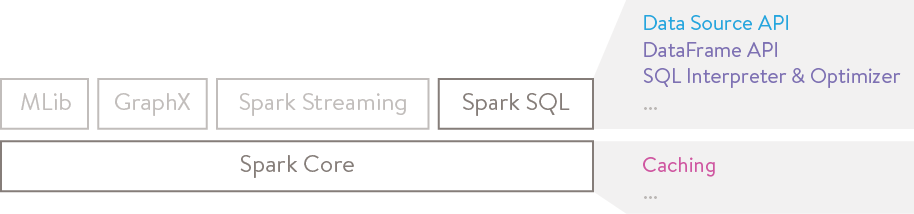

In [9]:
Image(im_2)

---
# Some code examples to whet your appetite!


## 1. Data `import`

The starting point for any data processing workflow is to read in data. The Spark data source API provides the ability to read structured data from a large number of input sources, including 

- Hive, 
- JSON, 
- CSV or textfiles

The data could be stored locally on a single machine or spread across a Cluster. 

> Note: The Spark API allows you to filter out data while importing. This is an important feature since it can avoid a lot of unnecessary reading.

---
```python
# Read from Hive (note: sc is an existing SparkContext)
from pyspark.sql import HiveContext

sqlContext = HiveContext(sc)
df_hive = sqlContext.sql("SELECT client, timestamp, items FROM client_table")
df_hive.show() # Show first rows of dataframe
df_hive.printSchema() # Show column names and types

# Read from JSON
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
df_json = sqlContext.read.json("path/client_table.json")
df_json.show()
df_json.printSchema()

# Read from CSV (Note: Requires installation of spark-csv lib)
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
df_csv = sqlContext.read.format('com.databricks.spark.csv').options(header='true')
                             .load('client_table.csv').select('client', 'timestamp')
df_csv.show()
df_csv.printSchema()
```
---
## 2. Caching Data

After data is read into Spark, one strategy to improve workload performance is to **cache tables in memory**. Only the first iteration of a task needs to be read from disk (which is slow) and all subsequent iterations can be read from memory (which is blazing fast).

#### When to use caching?

It is important to be thoughtful about what data is cached. If you run out of memory, data will spill over to disk from memory. Therefore, one should only cache data when it will be used in

- an iterative algorithm
- multiple downstream processes.
---

```python
from pyspark.sql import HiveContext
sqlContext = HiveContext(sc)

df_hive = sqlContext.sql("SELECT client, timestamp, items FROM client_table")

df_hive.cache()            # cache table in memory

N = 100                    # number of iterations
value = 0                  # starting value for function

for i in range(N):
	new_value = my_iter_func(df_hive, value)
           value = new_value
print 'final function output is: {value}'.format(value = value)
```
---
## 3. Transforming Data

Data frames are a relational representation of the popular `data.frame` in R, and `DataFrame` in Pandas. 
Spark has its own implementation, providing some (not all) of those features in a distributed context. 

There are two major advantages:

- **Simpler Code for complex tasks:** Spark dataframes allow data scientists to perform map/reduce type tasks without explicitly writing map/reduce commands. This results in code that is succinct, more intuitive, and ultimately quicker to develop.
- **Faster than Spark Core operations on RDDs**: Spark dataframes are highly optimized by a query optimizer and consequently significantly (about 6x) faster than using RDDs. 

---

## 3.1 Transformations via RDDs vs. DataFrames vs SQL

The example below compares writing a simple count and group by statement using dataframes vs the basic Spark data abstraction called an RDD.

---

```python
    # Transformation Using RDDs
    # ------------------------------
    
    data_rdd = sqlContext.sql("SELECT client, timestamp, items from client_table").rdd
    data_rdd.map(lambda x: (x[0], 1))
                  .reduceByKey(lambda x, y: x + y)
                  .map(lambda x: ( x[1], x[0] ))
                  .sortByKey(False)
                  .collect()



    # Transformation Using DataFrames
    # -------------------------------
    
    data = sqlContext.sql("SELECT client, timestamp, items from client_table")
    data.groupBy("client")
          .count()
          .orderBy("count")
          .show()

```

---
For users who feel more comfortable using SQL, they can start by caching the data frame in-memory as a table using the `registerTempTable()` command. Once cached, the table can be queried like a standard table in a relational database.


---
```python
# Transformation Using SQL
# ---------------------------

# 1. From Hive
data = sqlContext.sql("SELECT client, timestamp, items FROM client_table")

data.registerTempTable("data_t")

sqlContext.sql("SELECT client, count(*) FROM data_t").collect()

# 2. From csv
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
df = sqlContext.read.format('com.databricks.spark.csv').options(header='true')
                         .load('client_table.csv')

df.registerTempTable("df_t")

sqlContext.sql("SELECT client, count(*) FROM df_t").collect()
```

---

# `Apache Spark` 101
---

Most of base Spark's functionality is exposed via the `SparkContext` variable, which is automatically created for you when you start a new session. Try running

    sc
    type(sc)


If running `sc` does not give you an output, you might need to run the following.

    from pyspark import  SparkContext
    sc = SparkContext()


 Explore the `pyspark` environment

    sc.<tab>
    from pyspark import <tab>


### 1. RDD Basics

The basic data structure in Spark is the RDD or Resilient Distributed Dataset, which is essentially a collection of objects distributed over the storage medium.

All work in Spark is expressed in terms of RDDs operations like _Creation, Transformation, Actions._ Spark automatically distributes the data contained in RDDs across the cluster and parallelizes the operations performed on them.

---

## 1a. Creating a RDD from a file

The most common way of creating an RDD is to load it from a file. 
- Note: Spark's `textFile()` function can handle compressed files directly.    

---
### Using `sc.textFile`

- Read a text file from HDFS, a local file system (available on all
nodes), or any Hadoop-supported file system URI, and return it as an
RDD of Strings.

In [16]:
!head -5 kddcup.data_10_percent

0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.
0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,19,19,1.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,normal.
0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,29,29,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.
0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,39,39,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.
0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,49,49,1.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,normal.


In [18]:
raw_data = sc.textFile("kddcup.data_10_percent")

print type(raw_data)

<class 'pyspark.rdd.RDD'>


In [20]:
raw_data.take(5)

[u'0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.',
 u'0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,19,19,1.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,normal.',
 u'0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,29,29,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.',
 u'0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,39,39,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.',
 u'0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,49,49,1.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,normal.']

Here,

- We use `textFile()` to read the compressed dataset into an `RDD` object called `raw_data`.
- `raw_data` closely resembles a List of String objects, one object for each line in the dataset.
- We then use the `take()` method to print the first 5 elements of the `RDD`

---

### RDD Methods

Explore the available methods and attributes.

    raw_data.<tab>

Here, an RDD called `raw_data` is created. 
- Each element of the RDD is a string at this moment.


RDDs have access to some basic **methods** that can be used to retrieve important information about the data. These include `count()` and `take()`

In [21]:
# Take a look at the first few lines of the dataset
raw_data.take(2)

[u'0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.',
 u'0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,19,19,1.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,normal.']

In [22]:
# Find the number of lines in our dataset
raw_data.count()

494021

In [23]:
len(raw_data.take(1)[0].split(','))

42

In [24]:
raw_data_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 
                  'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 
                  'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 
                  'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 
                  'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 
                  'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 
                  'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 
                  'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 
                  'dst_host_srv_rerror_rate', 'interaction_type']

In [25]:
len(raw_data_names)

42

---
## 1b. Creating RDDs from Python objects using `parallelize()`

The `sparkContext` variable has access to the `parallelize` method which takes an existing Python list and converts it into an RDD.

> `sc.parallelize` will distribute a local Python collection to form an RDD

In [ ]:
sc.parallelize?

In [26]:
import numpy as np 

print type(range(100))
print type(np.arange(100))
print type(xrange(100))

<type 'list'>
<type 'numpy.ndarray'>
<type 'xrange'>


In [27]:
py_data = sc.parallelize(xrange(100))
type(py_data)

pyspark.rdd.PipelinedRDD

We can now inspect this RDD with the methods we have used above.

In [28]:
py_data.count()

100

In [29]:
py_data.take(15)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

---

> ## PS: `Spark` is Lazy. <br> Spark runs calculations only when they're needed.

In the example above, Spark waited to load the data file into an RDD until `raw_data.take(5)` was run.

When `raw_data = sc.textFile("dail_show.tsv")` was called, a pointer to the file was created, but only when `raw_data.take(5)` needed the file to run its logic was the text file actually read into raw_data.



---

## Remember:: Base Python Functional Programming

```python
    map(func, iterable)
    reduce(func, iterable)
    filter(func, iterable)
```    

In [30]:
iter_1 = range(1000)

print "The sqrt of all numbers in the list using a Map function. Showing the first 5."
print map(np.sqrt, iter_1)[:5]

print "Show only those numbers that are perfect squares. Only the first 5 results."
print filter(lambda x: int(np.sqrt(x)) == np.sqrt(x), iter_1)[:5]

print "Finding the sum of the numbers"
print reduce(lambda x, y: x + y, iter_1)

The sqrt of all numbers in the list using a Map function. Showing the first 5.
[0.0, 1.0, 1.4142135623730951, 1.7320508075688772, 2.0]
Show only those numbers that are perfect squares. Only the first 5 results.
[0, 1, 4, 9, 16]
Finding the sum of the numbers
499500


---

# 2. Essential RDD Operations

Spark Operations on RDDs are categorized into 
- _Transformations_: create new RDDs. 
    - Examples - `map()` and `filter()`
- _Actions_: run computations that produce a result. 
    - Example - `collect()`

> Note: Actual (distributed) computations in Spark take place when we execute *actions* and not *transformations*. We can apply as many transformations as we want on an RDD and no computation will take place until we call the first action.

---
## 2.1a The `filter()` Transformation

Remember that RDD objects, being immutable, can't be changed once created.

> The only way to `filter` data is to create a new RDD object without those rows of data.

`filter(f)` allows us to create a new RDD from an existing one containing only the elements meeting our criteria.
We specify a function `f` that returns either `True` or `False`, and the resulting RDD consists of elements where the function evaluated to `True`.

`filter` can be applied to subset larger RDDs in order to create new RDDs that contain only those objects that satisfy a given criterion. Specifically, we run a function against each RDD element, and return only those elements where the function evaluates to `True`.

> This is analogous to Boolean subsetting.

In [ ]:
# Filtering Collections in Base Python
# syntax: filter(function, collection)

lst = xrange(100)

# List comprehension to subset a list in Python code
print [i for i in lst if i % 2 == 0][:5]

# Use the filter FP function to subset a list in Python code
print filter(lambda x: x % 2 == 0, lst)[:5]

## Filtering an RDD

In [31]:
raw_data.take(2)

[u'0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.',
 u'0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,19,19,1.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,normal.']

In [34]:
raw_data_names[-5:]

['dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'interaction_type']

Inspecting our data, we observe that there are certain cases that are marked 'normal.'

In order to count the number of such cases, we might employ a `lambda` function passed to `filter()`.

In [35]:
# Non Normal Interactions
raw_data.filter(lambda x: 'normal.' not in x).count()/float(raw_data.count())

0.8030893423558918

In [36]:
raw_data.filter(lambda x: x.split(',')[-1] != 'normal.').count()/float(raw_data.count())

0.8030893423558918

In [37]:
normal_interactions_rdd = raw_data.filter(lambda x: 'normal.' in x)

---
### 2.1b The `map()` Transformation

> `map` will take a existing Python function or user-defined (also `lambda`) function and apply it to each element of the RDD.

Our input data is comma-delimited. We can apply a lambda function to each line in our data and obtain a dataFrame like object.

In [ ]:
map?

In [ ]:
# Map on Collections in Base Python
# syntax: map(function, collection)

lst = range(100)
map(lambda x: x + 10, lst)[:5]

In [38]:
# RDD Map transformation using a lambda function

csv_data = raw_data.map(lambda x: x.split(','))
print type(csv_data)

<class 'pyspark.rdd.PipelinedRDD'>


In [42]:
print csv_data.take(2)

[[u'0', u'tcp', u'http', u'SF', u'181', u'5450', u'0', u'0', u'0', u'0', u'0', u'1', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'8', u'8', u'0.00', u'0.00', u'0.00', u'0.00', u'1.00', u'0.00', u'0.00', u'9', u'9', u'1.00', u'0.00', u'0.11', u'0.00', u'0.00', u'0.00', u'0.00', u'0.00', u'normal.'], [u'0', u'tcp', u'http', u'SF', u'239', u'486', u'0', u'0', u'0', u'0', u'0', u'1', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'8', u'8', u'0.00', u'0.00', u'0.00', u'0.00', u'1.00', u'0.00', u'0.00', u'19', u'19', u'1.00', u'0.00', u'0.05', u'0.00', u'0.00', u'0.00', u'0.00', u'0.00', u'normal.']]


In [43]:
len(csv_data.take(1)[0]) == 42

True

In [44]:
# RDD map() transformation using a UDF

def parse_dict(line):
    """
    Takes a string, converts it to a list called 'elems'
    Extracts the 41st element called 'tag'
    Creates a dict with tag, elems
    """
    elems = line.split(',')
    tag = elems[41]
    return {'tag': tag, 'elems': elems}
    
key_csv_data = raw_data.map(parse_dict)

In [45]:
type(key_csv_data)

pyspark.rdd.PipelinedRDD

In [46]:
print key_csv_data.take(2)

[{'tag': u'normal.', 'elems': [u'0', u'tcp', u'http', u'SF', u'181', u'5450', u'0', u'0', u'0', u'0', u'0', u'1', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'8', u'8', u'0.00', u'0.00', u'0.00', u'0.00', u'1.00', u'0.00', u'0.00', u'9', u'9', u'1.00', u'0.00', u'0.11', u'0.00', u'0.00', u'0.00', u'0.00', u'0.00', u'normal.']}, {'tag': u'normal.', 'elems': [u'0', u'tcp', u'http', u'SF', u'239', u'486', u'0', u'0', u'0', u'0', u'0', u'1', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'8', u'8', u'0.00', u'0.00', u'0.00', u'0.00', u'1.00', u'0.00', u'0.00', u'19', u'19', u'1.00', u'0.00', u'0.05', u'0.00', u'0.00', u'0.00', u'0.00', u'0.00', u'normal.']}]


The code above will create a `dict` object for every case in our data. 

The RDD `key_csv_data` will be a list of dicts.

---
### 2.1c The `collect()` Action

It is used to get all RDD elements into memory for us to work with them. 
> For this reason it has to be used with care, specially when working with large RDDs. 

In [47]:
all_data = raw_data.collect()
type(all_data)

list

In [48]:
len(all_data)

494021

In [49]:
all_data[:5]

[u'0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.',
 u'0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,19,19,1.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,normal.',
 u'0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,29,29,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.',
 u'0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,39,39,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.',
 u'0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,49,49,1.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,normal.']

In [50]:
%timeit raw_data.count()

1 loop, best of 3: 3.94 s per loop


`raw_data` is an RDD, so running an action on it takes a while.

In [51]:
%timeit len(all_data)

The slowest run took 28.40 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 149 ns per loop


`all_data` is a list in-memory, so it runs super fast.

In [52]:
filtered_data = raw_data.filter(lambda x: 'normal' in x).collect()
type(filtered_data)

list

Now these datasets (`all_data` and `filtered_data`) are available to us in memory.

---
# 3. RDD Sampling

Spark offers two functions to accomplish sampling of data in an RDD - `sample()` and `takeSample()`

### 3a. The `sample()` function (a _Transformation_) 

- Application:
- Useful in a pipeline of transformations 
    - When you want to apply subsequent transformations to the sampled data
    - And then apply MLlib to the result
    

**Syntax:** 

    myRDD.sample(withReplacement, fraction, seed=None)

- Takes as *arguments* the following
    - with or without replacement
    - fraction of data to sample
    - random seed





In [53]:
raw_data.sample(False, 0.1, 112358).count()

49471

In [55]:
(raw_data
 .sample(False, 0.1)
#  .map(lambda x: x.split(','))
 .filter(lambda x: 'http' in x)
 .count()
)

6414

In [56]:
sampled_rdd = raw_data.sample(False, 0.05)
type(sampled_rdd)

pyspark.rdd.PipelinedRDD

**--- Note ---**

This could be especially helpful if we want to estimate a metric on a sample of the data to make inferences about the population. As the population is Big Data, we can quickly use sampling to get a fair idea.

---
### 3b. The `takeSample()` function (an _Action_)


If what we need is to grab a **fixed size** sample of raw data from our RDD into local memory in order to be used by other non-Spark libraries, `takeSample()` can be used.  

- Particularly helpful if we intend to apply ML algorithms on the sampled data
- The sample is available in-memory, so you can run `scikit-learn` algorithms on it

**Syntax**: 

    myRDD.takeSample(withReplacement, num, seed=None)

In [57]:
sampled = csv_data.takeSample(False, 10**4)

In [58]:
type(sampled)

list

In [59]:
len(sampled)
# This is now a list on our local environment

10000

> Now that the sampled data is available in memory, we can use `pandas` or any other non-Spark library on it!

In [61]:
from pandas import DataFrame

df_sampledRDD = DataFrame([x for x in sampled if 'http' in x], columns=raw_data_names)
df_sampledRDD.iloc[:10, :5]

,duration,protocol_type,service,flag,src_bytes
0,0,tcp,http,SF,54540
1,0,tcp,http,REJ,0
2,0,tcp,http,REJ,0
3,0,tcp,http,SF,334
4,0,tcp,http,SF,320
5,0,tcp,http,SF,250
6,0,tcp,http,SF,206
7,0,tcp,http,SF,327
8,0,tcp,http,SF,206
9,0,tcp,http,SF,201


In [62]:
df_sampledRDD.interaction_type.value_counts()

normal.     1198
back.         40
neptune.       3
Name: interaction_type, dtype: int64

---
# 4. Set operations on RDDs

On RDDs of the same type, Spark supports Set Operations like Union, Intersection etc. which are straightforward and work as expected. 

> But since RDDs are not real sets, operations such as the union of RDDs doesn't remove duplicates. 

These functions are available as RDD methods.

`.subtract(), .distinct()`, and `.cartesian()` are some of the most commonly used ones.

---
### 4.1 `subtract()` to find elements of A not in B 

In [63]:
not_normal = raw_data.subtract(raw_data.filter(lambda x: "normal." in x))
print type(not_normal)
print "There are {} non-normal interactions \nfrom a total of {} interactions".format(not_normal.count(), raw_data.count())

<class 'pyspark.rdd.PipelinedRDD'>
There are 396743 non-normal interactions 
from a total of 494021 interactions


---
### 4.2 `distinct()` to find unique values in A

Given that 'protocol' is the second column and 'service' is the third in `raw_data`, let's find distinct values for each and put them in separate RDDs.

In [64]:
protocols = csv_data.map(lambda x: x[1]).distinct()
services = csv_data.map(lambda x: x[2]).distinct()

print protocols.collect(), '\n'
print services.collect(), '\n'
print type(protocols)
print type(services)

[u'icmp', u'tcp', u'udp'] 

[u'supdup', u'domain', u'http', u'whois', u'netstat', u'netbios_dgm', u'time', u'smtp', u'gopher', u'private', u'name', u'ctf', u'ntp_u', u'red_i', u'vmnet', u'tim_i', u'klogin', u'nnsp', u'mtp', u'hostnames', u'pop_2', u'urp_i', u'Z39_50', u'eco_i', u'ftp_data', u'pm_dump', u'systat', u'ftp', u'sql_net', u'efs', u'remote_job', u'finger', u'ldap', u'kshell', u'iso_tsap', u'ecr_i', u'nntp', u'printer', u'telnet', u'uucp', u'auth', u'http_443', u'tftp_u', u'login', u'echo', u'sunrpc', u'urh_i', u'uucp_path', u'daytime', u'other', u'pop_3', u'netbios_ns', u'shell', u'domain_u', u'courier', u'exec', u'rje', u'link', u'ssh', u'netbios_ssn', u'csnet_ns', u'X11', u'IRC', u'bgp', u'discard', u'imap4'] 

<class 'pyspark.rdd.PipelinedRDD'>
<class 'pyspark.rdd.PipelinedRDD'>


---
### 4.3 `cartesian()` to find all possible combinations of elements in A and B

We can use this to generate all the possible combinations between services and protocol in our network interactions data.

In [ ]:
product = protocols.cartesian(services)

print product.collect()[:15]
print '\n', type(product)
print "\n There are {} combinations of protocol X service".format(len(product.collect()))

> For such small RDDs doesn't really makes sense to use Spark cartesian product. Note that `distinct` and `cartesian` are expensive operations so they must be used with care when the operating datasets are large. 

We could have used `collect()` on the values after using `distinct()` and done the cartesian product **locally**. 

---
# 5. Aggregations on RDDs



We can aggregate RDD data in Spark by using three different actions: `reduce`, `fold`, and `aggregate`. 

- `rdd.reduce(operator)`: using the specified commutative and associative binary operator 
    - Reduces the elements of an RDD 
    - Currently reduces partitions locally.


- `rdd.fold(zeroValue, operator)`: using a given associative and commutative function and a neutral "zero value," it
    - First, it aggregates the elements of each partition, and 
    - Then the results for all the partitions
    

- `rdd.aggregate(zeroValue, seq_Operator, comb_Operator)`: using given combine functions and a neutral "zero
value.
    - Aggregate the elements of each partition, and 
    - Then the results for all the partitions

Example:

     seqOp = (lambda x, y: (x[0] + y, x[1] + 1))
     combOp = (lambda x, y: (x[0] + y[0], x[1] + y[1]))
     sc.parallelize([1, 2, 3, 4]).aggregate((0, 0), seqOp, combOp)
     (10, 4)

`aggregate` is more general and, in a sense, includes the first two.  

---
> ### `reduce()` 

> Apply a function of two arguments cumulatively to the items of a sequence,
from left to right, so as to reduce the sequence to a single value.


---

In [65]:
rdd_1 = sc.parallelize([1, 2, 3, 4])
print rdd_1.getNumPartitions()

4


In [66]:
seqOp = (lambda x, y: (x[0] + y, x[1] + 1))
# Convert the number on each partition into a (number, count) tuple

combOp = (lambda x, y: (x[0] + y[0], x[1] + y[1]))
# Will sum the numbers and the counts for each.

rdd1_agg = rdd_1.aggregate((0, 0), seqOp, combOp)
rdd1_agg[0]/float(rdd1_agg[1])

2.5

In [67]:
# Start with the csv data
print csv_data.take(1)
print '\n Number of records:', csv_data.count()

[[u'0', u'tcp', u'http', u'SF', u'181', u'5450', u'0', u'0', u'0', u'0', u'0', u'1', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'8', u'8', u'0.00', u'0.00', u'0.00', u'0.00', u'1.00', u'0.00', u'0.00', u'9', u'9', u'1.00', u'0.00', u'0.11', u'0.00', u'0.00', u'0.00', u'0.00', u'0.00', u'normal.']]

 Number of records: 494021


In [68]:
normal_csv_data = csv_data.filter(lambda x: 'normal.' in x)
attack_csv_data = csv_data.filter(lambda x: 'normal.' not in x)

print normal_csv_data.count(), attack_csv_data.count()
print '\n', normal_csv_data.take(1)
print '\n', attack_csv_data.take(1)

97278 396743

[[u'0', u'tcp', u'http', u'SF', u'181', u'5450', u'0', u'0', u'0', u'0', u'0', u'1', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'8', u'8', u'0.00', u'0.00', u'0.00', u'0.00', u'1.00', u'0.00', u'0.00', u'9', u'9', u'1.00', u'0.00', u'0.11', u'0.00', u'0.00', u'0.00', u'0.00', u'0.00', u'normal.']]

[[u'184', u'tcp', u'telnet', u'SF', u'1511', u'2957', u'0', u'0', u'0', u'3', u'0', u'1', u'2', u'1', u'0', u'0', u'1', u'0', u'0', u'0', u'0', u'0', u'1', u'1', u'0.00', u'0.00', u'0.00', u'0.00', u'1.00', u'0.00', u'0.00', u'1', u'3', u'1.00', u'0.00', u'1.00', u'0.67', u'0.00', u'0.00', u'0.00', u'0.00', u'buffer_overflow.']]


The first column of each of these RDDs is `duration`. 

### To find the _mean duration_ for  `normal` and `attack` data, 

### Method 1: Sum divided by Count

- we first isolate the data for durations
- implement `aggregate` on this data to find the sum of durations
- divide the sum by count to get average

In [69]:
normal_sum = (normal_csv_data
               .map(lambda x: int(x[0]))
               .reduce(lambda x, y: x + y))

attack_sum = (attack_csv_data
              .map(lambda x: int(x[0]))
              .reduce(lambda x, y: x + y))

print 'The average duration of normal interactions is {}'.format(round(normal_sum/float(normal_csv_data.count()), 2))
print 'The average duration of attack interactions is {}'.format(round(attack_sum/float(attack_csv_data.count()), 2))

The average duration of normal interactions is 216.66
The average duration of attack interactions is 6.62


---
**NOTE:**

A. 

Since we're on Python 2.7, _division of two ints will yield an int._
Hence, we convert the denominator to float explicitly.

- Alternatively, we can use `from __future__ import division` and then do normat x/y type operations.


B. 

Also, the string with `print` has a `.format` method that can be used to pass a value.

- This method can be used to convert an `str` to numeric.


---

### Method 2: Use `aggregate()`

With `aggregate`, like with `fold`, we supply 

- an initial zero value of the type we want to return. 
- Then we provide two functions. 
    - The first one is used to combine the elements from our RDD with the accumulator. 
    - The second function is needed to merge two accumulators. 
    
Here's an example to find the mean.

In [70]:
normal_sum_count = (normal_csv_data
                    .map(lambda x: int(x[0]))
                    .aggregate((0, 0),
                               (lambda acc, value: (acc[0] + value, acc[1] + 1)),
                               (lambda acc1, acc2: (acc1[0] + acc2[0], acc1[1] + acc2[1]))))

attack_sum_count = (attack_csv_data
                    .map(lambda x: int(x[0]))
                    .aggregate((0, 0),
                               (lambda acc, value: (acc[0] + value, acc[1] + 1)),
                               (lambda acc1, acc2: (acc1[0] + acc2[0], acc1[1] + acc2[1]))))

print normal_sum_count, attack_sum_count

print 'Mean Normal Duration {}'.format(round(normal_sum_count[0]/float(normal_sum_count[1]), 2))
print 'Mean Attack Duration {}'.format(round(attack_sum_count[0]/float(attack_sum_count[1]), 2))

(21075991, 97278) (2626792, 396743)
Mean Normal Duration 216.66
Mean Attack Duration 6.62


---

## 6. Aggregations on Key-Value pair RDDs

We can use all the `transformations` and `actions` available for normal RDDs with key/value pair RDDs by rewriting the functions so they work with pair elements.

### `reduceByKey()`

Syntax: `rdd.reduceByKey(func, numPartitions=None)`

- Merges the values for each key using an associative reduce function.
- Also performs the merging locally on each mapper before sending results to a reducer

In the example below, we use the `map` transformation to create a key-value pair RDD (each pair as a tuple) and then use the `reduceByKey` transformation on it.

In [ ]:
print csv_data.take(1)

In [ ]:
# First create an RDD with key-value pairs 
# Here, {key: interaction type, value: duration}
key_value_duration = csv_data.map(lambda x: (x[41], float(x[0]))) 
key_value_duration.take(5)

In [ ]:
# How many kinds of interactions are there anyway?
print "No. of types of interactions: {}".format(csv_data.map(lambda x: x[41]).distinct().count())

In [ ]:
# For each key, we want to sum the durationss
durations_by_key = key_value_duration.reduceByKey(lambda x, y: x + y)
durations_by_key.collect()

---
### `countByKey()`

This function is used to count the number of elements for each key, and return the result to the master as a dictionary.

Syntax: `kvRDD.countByKey()`

In [ ]:
key_value_duration.countByKey()

---
### `combineByKey()`

It is a _generic_ function to combine the elements for each key using a _custom_ set of aggregation functions.

- Most general of the per-key aggregation functions. 
    - Infact, most of the other per-key combiners are implemented using it. 
- Think about it as the equivalent to `aggregate` as it allows the user to return values that are not the same type as the input data.

Syntax: `kvRDD.combineByKey(createCombiner, mergeValue, mergeCombiners, numPartitions=None)`



In [ ]:
sum_counts = key_value_duration.combineByKey(
    (lambda x: (x, 1)), # the initial value, with value x and count 1
    (lambda acc, value: (acc[0]+value, acc[1]+1)), # how to combine a pair value with the accumulator: sum value, and increment count
    (lambda acc1, acc2: (acc1[0]+acc2[0], acc1[1]+acc2[1])) # combine accumulators
)

sum_counts.collect()

In [ ]:
sum_counts.collectAsMap()

In [ ]:
duration_means_by_type = sum_counts.map(lambda (key,value): (key, round(value[0]/value[1],3))).collectAsMap()
duration_means_by_type

In [ ]:
print "Mean of Duration for normal interactions "

(csv_data
 .filter(lambda x: 'normal' in x[41])
 .map(lambda y: float(y[0]))
 .mean())

In [ ]:
print "Mean of Duration for non-normal interactions " 

(csv_data
 .filter(lambda x: 'normal' not in x[41])
 .map(lambda y: float(y[0]))
 .mean())

In [ ]:
(csv_data
 .map(lambda y: y[41])
 .top(num=5))

### Now move to the pyspark-pictures-RDD notebook to explore more RDD methods